# Multi-modal RAG with Google Cloud

This tutorial demonstrates how to implement the Option 2 described [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb) with Generative API on Google Cloud.

## Setup

Install the required dependencies, and create an API key for your Google service.

In [ ]:
%pip install -U --quiet langchain langchain_community openai chromadb langchain-experimental
%pip install --quiet "unstructured[all-docs]" pypdf pillow pydantic lxml pillow matplotlib chromadb tiktoken

## Data loading

We use a zip file with a sub-set of the extracted images and pdf from [this](https://cloudedjudgement.substack.com/p/clouded-judgement-111023) blog post. If you want to follow the full flow, please, use the original [example](https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb).

In [1]:
# First download
import logging
import zipfile

import requests

logging.basicConfig(level=logging.INFO)

data_url = "https://storage.googleapis.com/benchmarks-artifacts/langchain-docs-benchmarking/cj.zip"
result = requests.get(data_url)
filename = "cj.zip"
with open(filename, "wb") as file:
    file.write(result.content)

with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall()

In [2]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("./cj/cj.pdf")
docs = loader.load()
tables = []
texts = [d.page_content for d in docs]

In [3]:
len(texts)

21

## Multi-vector retriever

Let's generate text and image summaries and save them to a ChromaDB vectorstore.

In [4]:
from langchain.chat_models import ChatVertexAI
from langchain.llms import VertexAI
from langchain.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableLambda


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    empty_response = RunnableLambda(
        lambda x: AIMessage(content="Error processing document")
    )
    # Text summary chain
    model = VertexAI(
        temperature=0, model_name="gemini-pro", max_output_tokens=1024
    ).with_fallbacks([empty_response])
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts, tables, summarize_texts=True
)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
len(text_summaries)

21

In [6]:
import base64
import os

from langchain.schema.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    model = ChatVertexAI(model_name="gemini-pro-vision", max_output_tokens=1024)

    msg = model(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries("./cj")

In [7]:
len(image_summaries)

5

In [8]:
import uuid

from langchain.embeddings import VertexAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog",
    embedding_function=VertexAIEmbeddings(model_name="textembedding-gecko@latest"),
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


## Building a RAG

Let's build a retriever:

In [9]:
import io
import re

from IPython.display import HTML, display
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    if len(b64_images) > 0:
        return {"images": b64_images[:1], "texts": []}
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatVertexAI(
        temperature=0, model_name="gemini-pro-vision", max_output_tokens=1024
    )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

Let's check that we get images as documents:

In [10]:
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=1)

# We get 2 docs
len(docs)

4


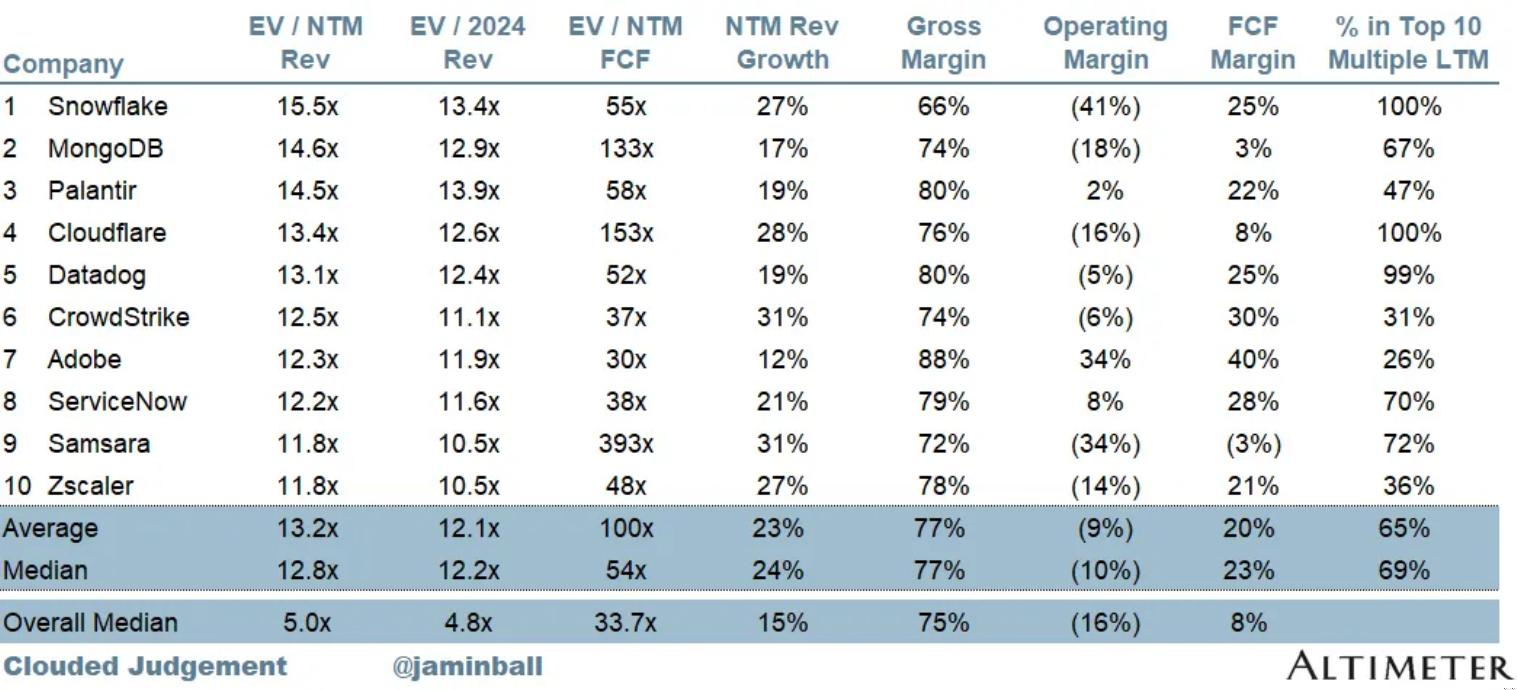

In [11]:
plt_img_base64(docs[0])

And let's run our RAG on the same query:

In [12]:
chain_multimodal_rag.invoke(query)

' | Company | EV / NTM Rev | NTM Rev Growth |\n|---|---|---|\n| MongoDB | 14.6x | 17% |\n| Cloudflare | 13.4x | 28% |\n| Datadog | 13.1x | 19% |'

As we can see, the model was able to figure out the the right values that are relevant to answer the question.